In [1]:
# Imports
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.preprocessing import \
    (StandardScaler, OneHotEncoder,
    LabelEncoder, PolynomialFeatures, OrdinalEncoder)
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.metrics import \
    (confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, accuracy_score)
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [2]:
# Adjust default matplotlib settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.labelpad'] = 10
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

In [3]:
# Read in data
df_cces = pd.read_parquet('../Data/CCES/CCES_Panel_cleaned.parquet')

In [4]:
df_cces

,caseid,weight,year,301_1,301_2,301_3,301_4,301_5,301b,302,...,pew_churatd,pew_prayer,pew_religimp,phone,pid3,pid7,race,religpew,union,unionhh
0,25233,0.538062,2010,Yes,Yes,Yes,Yes,No,Both,Gotten much worse,...,Once or twice a month,A few times a week,Somewhat important,Both,Independent,Lean Republican,White,Roman Catholic,Formerly,"No, never"
1,38716,3.470877,2010,Yes,No,Yes,Yes,No,NaN,Stayed about the same,...,Never,Never,Not at all important,Cell only,Democrat,Not very strong Democrat,White,Nothing in particular,"No, never","No, never"
2,7796,0.602477,2010,No,Yes,Yes,Yes,No,Both,Gotten worse,...,More than once a week,Several times a day,Very important,Both,Republican,Strong Republican,White,Mormon,Formerly,Formerly
3,78113,0.264208,2010,Yes,Yes,Yes,Yes,No,Both,Gotten better,...,Never,Never,Not at all important,Cell only,Democrat,Strong Democrat,White,Nothing in particular,"No, never","No, never"
4,63800,0.196632,2010,Yes,Yes,Yes,No,No,Both,Gotten better,...,Seldom,Never,Not too important,Both,Democrat,Strong Democrat,White,Protestant,"No, never","No, never"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28495,57290,1.146715,2014,No,No,No,No,Yes,NaN,Gotten better,...,Never,A few times a month,Somewhat important,Cell only,Democrat,Strong Democrat,Hispanic,Something else,"No, never",Formerly
28496,57315,1.171217,2014,No,No,No,No,Yes,NaN,Stayed about the same,...,A few times a year,A few times a week,Somewhat important,Cell only,Republican,Strong Republican,Hispanic,Roman Catholic,"No, never","No, never"
28497,57399,0.424949,2014,No,Yes,No,No,No,Local Newscast,Gotten much better,...,Never,Seldom,Not at all important,Both,Democrat,Strong Democrat,Hispanic,Something else,"No, never",Formerly
28498,59331,0.505942,2014,No,Yes,No,Yes,No,Local Newscast,Gotten worse,...,Once a week,Once a day,Very important,Cell only,Republican,Strong Republican,Hispanic,Mormon,"Yes, currently","No, never"


In [5]:
# Create subsets for every year for naïve guess
df_cces10 = df_cces.query('year == 2010') \
    .reset_index(drop=True)
df_cces12 = df_cces.query('year == 2012') \
    .reset_index(drop=True)
df_cces14 = df_cces.query('year == 2014') \
    .reset_index(drop=True)

In [6]:
# Sort values to create lagged dv
df_cces = df_cces.sort_values(['caseid', 'year']) \
    .reset_index(drop=True)

In [7]:
df_cces

,caseid,weight,year,301_1,301_2,301_3,301_4,301_5,301b,302,...,pew_churatd,pew_prayer,pew_religimp,phone,pid3,pid7,race,religpew,union,unionhh
0,1,0.956946,2010,No,Yes,Yes,Yes,No,Both,Gotten much worse,...,Once a week,Once a day,Very important,Both,Republican,Strong Republican,White,Protestant,"No, never","No, never"
1,1,0.956946,2012,No,Yes,Yes,Yes,No,Both,Gotten much worse,...,Once a week,Several times a day,Very important,Cell only,Republican,Strong Republican,White,Protestant,"No, never","No, never"
2,1,0.956946,2014,No,Yes,Yes,Yes,No,National Newscast,Gotten worse,...,Once or twice a month,Several times a day,Very important,Both,Republican,Not very strong Republican,White,Protestant,"No, never","No, never"
3,24,1.847343,2010,Yes,Yes,Yes,No,No,National Newscast,Stayed about the same,...,Never,Never,Not at all important,Both,Republican,Not very strong Republican,White,Agnostic,"No, never","No, never"
4,24,1.847343,2012,Yes,Yes,Yes,No,No,Both,Gotten better,...,Never,Never,Not at all important,Both,Independent,Independent,White,Atheist,"No, never","No, never"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28495,85318,1.747243,2012,No,Yes,Yes,No,No,Both,Gotten better,...,Never,Never,Not at all important,Both,Independent,Independent,White,Something else,"Yes, currently","No, never"
28496,85318,1.747243,2014,No,Yes,No,No,No,NaN,Stayed about the same,...,Never,Never,Not at all important,Both,Independent,Lean Democrat,White,Something else,"No, never","Yes, currently"
28497,85321,0.753324,2010,No,Yes,No,Yes,No,Both,Gotten much worse,...,Seldom,Several times a day,Somewhat important,Both,Republican,Strong Republican,White,Protestant,"No, never","No, never"
28498,85321,0.753324,2012,No,Yes,No,No,No,Both,Gotten much worse,...,Never,Several times a day,Very important,Both,Independent,Lean Republican,White,Protestant,"No, never","No, never"


In [8]:
# Create lag of the DV
df_cces['VV_primary_lag'] = df_cces.groupby('caseid')['VV_primary'].shift(1)
df_cces['VV_general_lag'] = df_cces.groupby('caseid')['VV_general'].shift(1)

In [9]:
# Check
df_cces[['caseid', 'year', 'VV_primary_lag', 'VV_primary']]

,caseid,year,VV_primary_lag,VV_primary
0,1,2010,NaN,Voted
1,1,2012,Voted,Voted
2,1,2014,Voted,Voted
3,24,2010,NaN,Voted
4,24,2012,Voted,Voted
...,...,...,...,...
28495,85318,2012,Abstained,Abstained
28496,85318,2014,Abstained,Abstained
28497,85321,2010,NaN,Abstained
28498,85321,2012,Abstained,Abstained


In [10]:
# Drop all rows where lag is missing = 2010
df_cces = df_cces.query('year != 2010').copy()

In [11]:
# Convert cdid to category to create dummies for district ID
df_cces['cdid'] = df_cces['cdid'].astype('category')

In [12]:
# Drop caseid and weight
df_cces = df_cces.drop(['caseid', 'weight'], axis=1)

In [13]:
# Write function to split into training and test set
def split_cces(df):
    df_train = df.query('year == 2012') \
        .drop('year', axis=1)
    df_test = df.query('year == 2014') \
        .drop('year', axis=1)
    
    return (df_train, df_test)

In [14]:
# Define class for metrics
class Metrics:
    
    def __init__(self, conf_matrix):
        """
        Initialize the Metrics object with true labels and predicted labels.
        """
        self.conf_matrix = conf_matrix
        self.TN, self.FP, self.FN, self.TP = self.conf_matrix.ravel()

    def accuracy(self):
        """
        Compute accuracy
        """
        return (self.TP + self.TN) / (self.TP + self.TN + self.FP + self.FN)

    def recall(self):
        """
        Compute recall (sensitivity or TPR)
        """
        return self.TP / (self.TP + self.FN) if (self.TP + self.FN) != 0 else 0

    def specificity(self):
        """
        Computr specificity (TNR)
        """
        return self.TN / (self.TN + self.FP) if (self.TN + self.FP) != 0 else 0

    def precision(self):
        """
        Compute precision
        """
        return self.TP / (self.TP + self.FP) if (self.TP + self.FP) != 0 else 0

    def f1_score(self):
        """
        Compute F1 score
        """
        precision = self.precision()
        recall = self.recall()
        return 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# DV: VV_primary

## Naïve guess

In [15]:
# 2010 and 2014
print(f"Naïve 2010 & 2014: {np.sum(df_cces10['VV_primary'] == df_cces14['VV_primary']) / 9500:.2%}")
# 2012 and 2014
print(f"Naïve 2012 & 2014: {np.sum(df_cces12['VV_primary'] == df_cces14['VV_primary']) / 9500:.2%}")

Naïve 2010 & 2014: 71.76%
Naïve 2012 & 2014: 71.21%


## Preprocessing

In [53]:
df_cces_1 = df_cces.drop(['VV_general_lag', 'VV_general'], axis=1)

In [54]:
# Split into training and test set
df_train, df_test = split_cces(df_cces_1)

In [55]:
# Number of samples per split
print(f'# Training samples: {len(df_train)} \
        # Test samples: {len(df_test)}')

# Training samples: 9500         # Test samples: 9500


In [56]:
X_train = df_train.drop('VV_primary', axis=1)
y_train = df_train['VV_primary'].to_numpy()
X_test = df_test.drop('VV_primary', axis=1)
y_test = df_test['VV_primary'].to_numpy()

In [57]:
# Encode targets
y_encoder = LabelEncoder()

y_train = y_encoder.fit_transform(y_train)
y_test = y_encoder.transform(y_test)

In [58]:
# Identify ordered categorical columns
ordered_cat_cols = [col for col in X_train.columns if pd.api.types.is_categorical_dtype(df_cces[col]) and df_cces[col].cat.ordered]
# Identify unordered cateforical columns
unordered_cat_cols = [col for col in X_train.columns if pd.api.types.is_categorical_dtype(df_cces[col]) and not df_cces[col].cat.ordered]

In [59]:
# Define dictionary for category order
category_order = {col: list(X_train[col].cat.categories) for col in ordered_cat_cols}

In [60]:
# One-hot encode only unordered categorical columns
# Ordered categorical columns are ordinally encoded
col_trans = ColumnTransformer(
    [(col,
      OneHotEncoder(drop='first',
                    sparse_output=False,
                    handle_unknown='ignore'),
     [col]) for col in unordered_cat_cols] +
    [(col,
      OrdinalEncoder(categories=[category_order[col]],
                     handle_unknown='use_encoded_value',
                     unknown_value=np.nan), 
      [col]) for col in ordered_cat_cols],
    remainder='passthrough'
)

# Impute missing values
knn_imputer = KNNImputer(missing_values=np.nan,
                         n_neighbors=3,
                         weights='distance')

# Scaling
scaler = StandardScaler(with_mean=True,
                        with_std=True)

In [61]:
# Define pipeline
pipe = Pipeline(steps=[('col_trans', col_trans),
                       ('knn_imputer', knn_imputer),
                       ('scaler', scaler)]).set_output(transform='pandas')

In [62]:
# Fit and apply pipe to training features
X_train = pipe.fit_transform(X_train)
# Apply pipe to test features
X_test = pipe.transform(X_test)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning:

In [63]:
# Check shape
X_train.shape[1] # 384 features

384

## Fit

In [64]:
# Tune regularization parameter
alphas = np.logspace(-4, -0.5, 100)  # Generate 30 values of alpha from 10^-4 to 10^-0.5
best_alpha = None
max_acc = 0

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    preds_proba_test = lasso.predict(X_test)
    preds_test = (preds_proba_test > .5).astype(int)
    acc = np.sum(preds_test == y_test) / len(y_test)
    if acc > max_acc:
        max_acc = acc
        best_alpha = alpha

print("Best alpha:", best_alpha)

Best alpha: 0.052749970637026196


In [65]:
# Initialize model
lasso = Lasso(alpha=best_alpha, max_iter=1_000)

In [66]:
# Fit model
lasso.fit(X_train, y_train)

Lasso(alpha=0.052749970637026196)

## Evaluate

In [67]:
preds_proba_train = lasso.predict(X_train)
preds_train = (preds_proba_train > .5).astype(int)

In [68]:
print(f'Training accuracy: {np.sum(preds_train == y_train)/len(y_train):.3f}')

Training accuracy: 0.719


In [69]:
preds_proba_test = lasso.predict(X_test)
preds_test = (preds_proba_test > .5).astype(int)

In [70]:
print(f'Test accuracy: {np.sum(preds_test == y_test)/len(y_test):.4f}')

Test accuracy: 0.7121


In [71]:
cmat = confusion_matrix(y_true=y_test, y_pred=preds_test)

In [72]:
cmat_disp = ConfusionMatrixDisplay(cmat, display_labels=y_encoder.classes_)

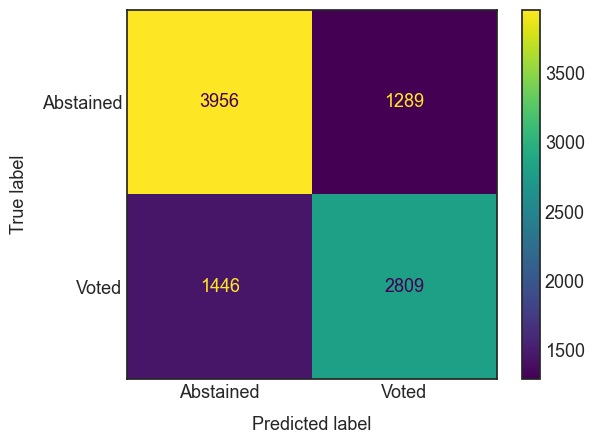

In [73]:
plt.style.use('seaborn-v0_8-white')
plt.rcParams['font.size'] = 13
cmat_disp.plot();

In [74]:
# Additional metrics for performance on test data
metrics = Metrics(cmat)
print(f'Accuracy: {metrics.accuracy():.2%}')
print(f'Sensitivity/Recall (TPR): {metrics.recall():.2%}')
print(f'Specificity (TNR): {metrics.specificity():.2%}')
print(f'Precision: {metrics.precision():.2%}')
print(f'F1: {metrics.f1_score():.2f}')
print(f'AUC: {roc_auc_score(y_test, preds_proba_test):.2f}')

Accuracy: 71.21%
Sensitivity/Recall (TPR): 66.02%
Specificity (TNR): 75.42%
Precision: 68.55%
F1: 0.67
AUC: 0.73


In [75]:
# Inspect features for which coefs are non-zero
for pos, mag in zip(np.where(lasso.coef_ != 0)[0], lasso.coef_[lasso.coef_!=0]):
    print(f"{X_train.iloc[:, pos].name:<{len('VV_primary_lag__VV_primary_lag_Voted')+1}} {mag:>10}")

309a__309a_Republicans                0.00023515416917545224
350__350_Republican Party             0.01437356891513311
417a_6__417a_6_Yes                    -0.008344999634407073
inputstate__inputstate_New York       -0.012751466246374167
religpew__religpew_Atheist            -0.006321341038279656
VV_primary_lag__VV_primary_lag_Voted  0.16104646354515703
newsint__newsint                      0.0024855018899510722


# DV: VV_General

## Naïve guess

In [76]:
# 2010 and 2014
print(f"Naïve 2010 & 2014: {np.sum(df_cces10['VV_general'] == df_cces14['VV_general']) / 9500:.2%}")
# 2012 and 2014
print(f"Naïve 2012 & 2014: {np.sum(df_cces12['VV_general'] == df_cces14['VV_general']) / 9500:.2%}")

Naïve 2010 & 2014: 75.20%
Naïve 2012 & 2014: 73.95%


## Preprocessing

In [77]:
df_cces_2 = df_cces.drop(['VV_primary_lag', 'VV_primary'], axis=1)

In [78]:
df_train, df_test = split_cces(df_cces_2)

In [80]:
# Number of samples per split
print(f'# Training samples: {len(df_train)} \
        # Test samples: {len(df_test)}')

# Training samples: 9500         # Test samples: 9500


In [81]:
X_train = df_train.drop('VV_general', axis=1)
y_train = df_train['VV_general'].to_numpy()
X_test = df_test.drop('VV_general', axis=1)
y_test = df_test['VV_general'].to_numpy()

In [82]:
# Encode targets
y_encoder = LabelEncoder()

y_train = y_encoder.fit_transform(y_train)
y_test = y_encoder.transform(y_test)

In [83]:
# Identify ordered categorical columns
ordered_cat_cols = [col for col in X_train.columns if pd.api.types.is_categorical_dtype(df_cces[col]) and df_cces[col].cat.ordered]
# Identify unordered cateforical columns
unordered_cat_cols = [col for col in X_train.columns if pd.api.types.is_categorical_dtype(df_cces[col]) and not df_cces[col].cat.ordered]

In [84]:
# Define dictionary for category order
category_order = {col: list(X_train[col].cat.categories) for col in ordered_cat_cols}

In [85]:
# One-hot encode only unordered categorical columns
# Ordered categorical columns are ordinally encoded
col_trans = ColumnTransformer(
    [(col,
      OneHotEncoder(drop='first',
                    sparse_output=False,
                    handle_unknown='ignore'),
     [col]) for col in unordered_cat_cols] +
    [(col,
      OrdinalEncoder(categories=[category_order[col]],
                     handle_unknown='use_encoded_value',
                     unknown_value=np.nan), 
      [col]) for col in ordered_cat_cols],
    remainder='passthrough'
)

# Impute missing values
knn_imputer = KNNImputer(missing_values=np.nan,
                         n_neighbors=13,
                         weights='distance')

# Scaling
scaler = StandardScaler(with_mean=True,
                        with_std=True)

In [86]:
# Define pipeline
pipe = Pipeline(steps=[('col_trans', col_trans),
                       ('knn_imputer', knn_imputer),
                       ('scaler', scaler)]).set_output(transform='pandas')

In [87]:
# Fit and apply pipe to training features
X_train = pipe.fit_transform(X_train)
# Apply pipe to test features
X_test = pipe.transform(X_test)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning:

In [88]:
# Check shape
X_train.shape[1] # 384 features

384

## Fit – No oversampling

In [89]:
# Tune regularization parameter
alphas = np.logspace(-4, -0.5, 100)  # Generate 30 values of alpha from 10^-4 to 10^-0.5
best_alpha = None
max_acc = 0

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    preds_proba_test = lasso.predict(X_test)
    preds_test = (preds_proba_test > .5).astype(int)
    acc = np.sum(preds_test == y_test) / len(y_test)
    if acc > max_acc:
        max_acc = acc
        best_alpha = alpha

print("Best alpha:", best_alpha)

Best alpha: 0.03236689285040602


In [90]:
# Initialize and fit model
lasso = Lasso(alpha=best_alpha, max_iter=1_000)
lasso.fit(X_train, y_train)

Lasso(alpha=0.03236689285040602)

## Evaluate

In [91]:
preds_proba_train = lasso.predict(X_train)
preds_train = (preds_proba_train > .5).astype(int)
print(f'Training accuracy: {np.sum(preds_train == y_train)/len(y_train):.4f}')

Training accuracy: 0.7958


In [92]:
preds_proba_test = lasso.predict(X_test)
preds_test = (preds_proba_test > .5).astype(int)
print(f'Test accuracy: {np.sum(preds_test == y_test)/len(y_test):.4f}')

Test accuracy: 0.7913


In [93]:
cmat = confusion_matrix(y_true=y_test, y_pred=preds_test)
cmat_disp = ConfusionMatrixDisplay(cmat, display_labels=y_encoder.classes_)

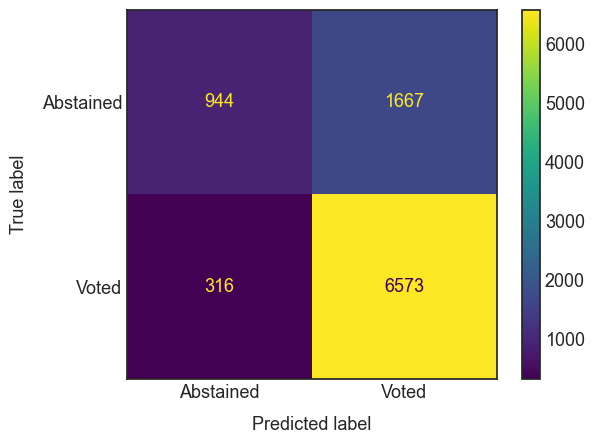

In [94]:
plt.style.use('seaborn-v0_8-white')
plt.rcParams['font.size'] = 13
cmat_disp.plot();

In [95]:
# Additional metrics for performance on test data
metrics = Metrics(cmat)
print(f'Accuracy: {metrics.accuracy():.2%}')
print(f'Sensitivity/Recall (TPR): {metrics.recall():.2%}')
print(f'Specificity (TNR): {metrics.specificity():.2%}')
print(f'Precision: {metrics.precision():.2%}')
print(f'F1: {metrics.f1_score():.2f}')
print(f'AUC: {roc_auc_score(y_test, preds_proba_test):.2f}')

Accuracy: 79.13%
Sensitivity/Recall (TPR): 95.41%
Specificity (TNR): 36.15%
Precision: 79.77%
F1: 0.87
AUC: 0.75


In [96]:
# Inspect features for which coefs are non-zero
for pos, mag in zip(np.where(lasso.coef_ != 0)[0], lasso.coef_[lasso.coef_!=0]):
    print(f"{X_train.iloc[:, pos].name:<{len('VV_primary_lag__VV_primary_lag_Voted')+1}} {mag:>10}")

309a__309a_Republicans                0.002031733168412618
317__317_nan                          -0.0022548807026641646
406a__406a_nan                        -0.08997879326101983
425a__425a_Yes                        0.0005528769696238969
425b_2__425b_2_nan                    -2.33357193218054e-16
religpew__religpew_Atheist            -0.07602887668923931
VV_general_lag__VV_general_lag_Voted  0.09624425115738547


## Fit – SMOTE

In [97]:
# Create pipeline
lasso_pipe = ImbPipeline([
    ('smote', SMOTE(sampling_strategy='minority', random_state=42, k_neighbors=3)),
    ('lasso', Lasso(alpha=best_alpha, max_iter=1_000))
])

In [98]:
# Fit model
lasso_pipe.fit(X_train, y_train)

Pipeline(steps=[('smote',
                 SMOTE(k_neighbors=3, random_state=42,
                       sampling_strategy='minority')),
                ('lasso', Lasso(alpha=0.03236689285040602))])

## Evaluate

In [99]:
preds_proba_train = lasso_pipe.predict(X_train)
preds_train = (preds_proba_train > .5).astype(int)
print(f'Training accuracy: {np.sum(preds_train == y_train)/len(y_train):.4f}')

Training accuracy: 0.7742


In [100]:
preds_proba_test = lasso_pipe.predict(X_test)
preds_test = (preds_proba_test > .5).astype(int)
print(f'Test accuracy: {np.sum(preds_test == y_test)/len(y_test):.4f}')

Test accuracy: 0.7564


In [101]:
cmat = confusion_matrix(y_true=y_test, y_pred=preds_test)
cmat_disp = ConfusionMatrixDisplay(cmat, display_labels=y_encoder.classes_)

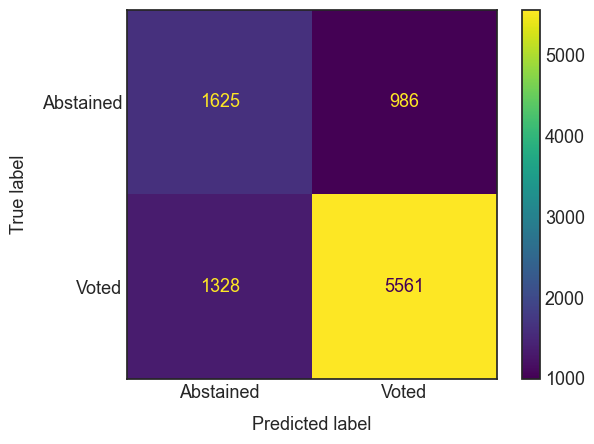

In [103]:
plt.style.use('seaborn-v0_8-white')
plt.rcParams['font.size'] = 13
cmat_disp.plot();

In [104]:
# Additional metrics for performance on test data
metrics = Metrics(cmat)
print(f'Accuracy: {metrics.accuracy():.2%}')
print(f'Sensitivity/Recall (TPR): {metrics.recall():.2%}')
print(f'Specificity (TNR): {metrics.specificity():.2%}')
print(f'Precision: {metrics.precision():.2%}')
print(f'F1: {metrics.f1_score():.2f}')
print(f'AUC: {roc_auc_score(y_test, preds_proba_test):.2f}')

Accuracy: 75.64%
Sensitivity/Recall (TPR): 80.72%
Specificity (TNR): 62.24%
Precision: 84.94%
F1: 0.83
AUC: 0.72
